# Heartrate Variability - Kalume Lab

Reads in an EDF file then:
1. Plots all data channels
2. Finds peaks in respiratory and cardiac data
3. Finds relationship between breath peaks and cardiac peaks
4. Finds spectral density of EMG and Right/Left EEG
5. (Future) Calculate coherence in Right/Left EEG
6. (Future) Calculate coherence between ECG, EEG, and EMG



## User Input

In [1]:
#dir_in = ''
dir_in = r"C:\Users\haley\Dropbox\Code\Heartrate_Variability\kalume_data"
#dir_in = r"D:\Dropbox\Code\Heartrate Variability\kalume_data"
file_in = r"Synchrony_EEG_ECG_RESP_K6527_HmzNdufsCrep_10_06_16_TISel.edf" 
amp_channels = [8,9,12] # Channel #s you want to analyze by amplitude
freq_channels = [10,11,13] # Channel #s you want to analyze by frequency
plot_start_time_mins = 0 # The time (in minutes) that you want to start analyzing the recording

# Values can be "all" (with quotation marks) or a number indicating the number of minutes 
plot_length_mins = "all"  # Length of Recording you wannt to analyze
template_start_time_mins = plot_start_time_mins  # Start time (in min) for defining the templates
template_search_length_mins = 0.05   # Length of recording for measuring the templates
sample_rate = 1000 # In Hz

# plot start can't be bigger plot_end
#template start needs fixing
# > 30s of stillness (in EMG)
# 50% overlap in FFT window of EMG

### Import Packages

In [2]:
import pyedflib
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

### Define General Functions

In [3]:
def datapoints_to_minutes(datapoints):
    """ Takes either a list or an int and converts to minutes based on sample rate"""
    if type(datapoints) == list:
        minutes = []
        for dp in datapoints:
            mins = dp / (60 * sample_rate)
            minutes.append(mins)
    else:
        minutes = datapoints / (60 * sample_rate)
    return minutes

def datapoints_to_ms(datapoints):
    """ Takes either a list or an int and converts to milliseconds based on sample rate"""
    if type(datapoints) == list:
        milliseconds = []
        for dp in datapoints:
            ms = dp / sample_rate * 1000
            milliseconds.append(int(ms))
    else:
        milliseconds = datapoints/ sample_rate *1000
    return milliseconds

def minutes_to_datapoints (minutes):
    """ Takes either a list or a float and converts to datapoints (int) based on sample rate"""
    if type(minutes) == list:
        datapoints = []
        for mins in minutes:
            dp = mins * (60 * sample_rate)
            datapoints.append(int(dp))
    else:
        datapoints = int(minutes * 60 * sample_rate)
    return datapoints

def get_plot_length (plot_length, sigbufs):
    """ Takes in a plot length in minutes (whole trace or a subsection of a trace)
        and returns it in datapoints"""
    if plot_length == 'all':
        plot_end_time = len(sigbufs[0,:])
    elif plot_length > len(sigbufs[0,:]):
        plot_end_time = len(sigbufs[0,:])
    elif plot_length < 0:
        print ("USER ERROR: Cannot plot a negative plot_length.")
    else:
        plot_end_time = plot_length * (60*sample_rate)
    return int(plot_end_time)

def get_edf (dir_in, file_in, file_open):
    """ Opens a Labchart EDF file from the specified file and directory"""
    if file_open == 0:
        file_name = os.path.join(dir_in, file_in)
        f = pyedflib.EdfReader(file_name)
        file_open = 1
    else:
        pass
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i,:] = f.readSignal(i)
    return signal_labels, sigbufs


def plot_anything (x, y , y_scale, x_label, y_label, dots):
    fig, ax = plt.subplots(figsize = (10,3), dpi = 100)

    if y_scale == 'minutes':
        y = datapoints_to_minutes(y)
    elif y_scale == 'seconds':
        y = datapoints_to_seconds(y)
    elif y_scale == 'ms':
        y = datapoints_to_ms(y)
    else:
        pass
    if dots == False:
        ax.plot(datapoints_to_minutes(x), y)
    elif dots == True:
        ax.plot(datapoints_to_minutes(x), y, marker = 'o', markersize = 2, mec = 'black')
    
    ax.set_xlabel (x_label)
    ax.set_ylabel (y_label)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax



### Default Values

In [4]:
file_open = 0   # 0 = EDF file hasn't been opened, 1 = it has been opened
threshold = 0
ground = 0
start = 0
plot_start_time_dp = int(plot_start_time_mins * 60 * sample_rate)
template_start_time_dp = int(template_start_time_mins * 60 * sample_rate)
template_search_length_dp = minutes_to_datapoints(template_search_length_mins)
template_end_time_dp = int (template_start_time_mins + template_search_length_dp)
all_channels = sorted(amp_channels + freq_channels)
all_signals = [chan - 1 for chan in all_channels]
amp_signals = [chan-1 for chan in amp_channels] 
freq_signals = [chan-1 for chan in freq_channels]

### Setup Signals

In [5]:
signal_labels, sigbufs = get_edf (dir_in, file_in, file_open) # reads in all signal labels
amp_labels = list(signal_labels[i] for i in amp_signals) # Labels for signals to be analyzed for amplitude
freq_labels = list(signal_labels[i] for i in freq_signals) # Labels for signals to be analyzed for frequency
plot_end_time_dp = int(plot_start_time_dp + get_plot_length (plot_length_mins, sigbufs)) # Gets plot length in datapoints

### Plot all signals

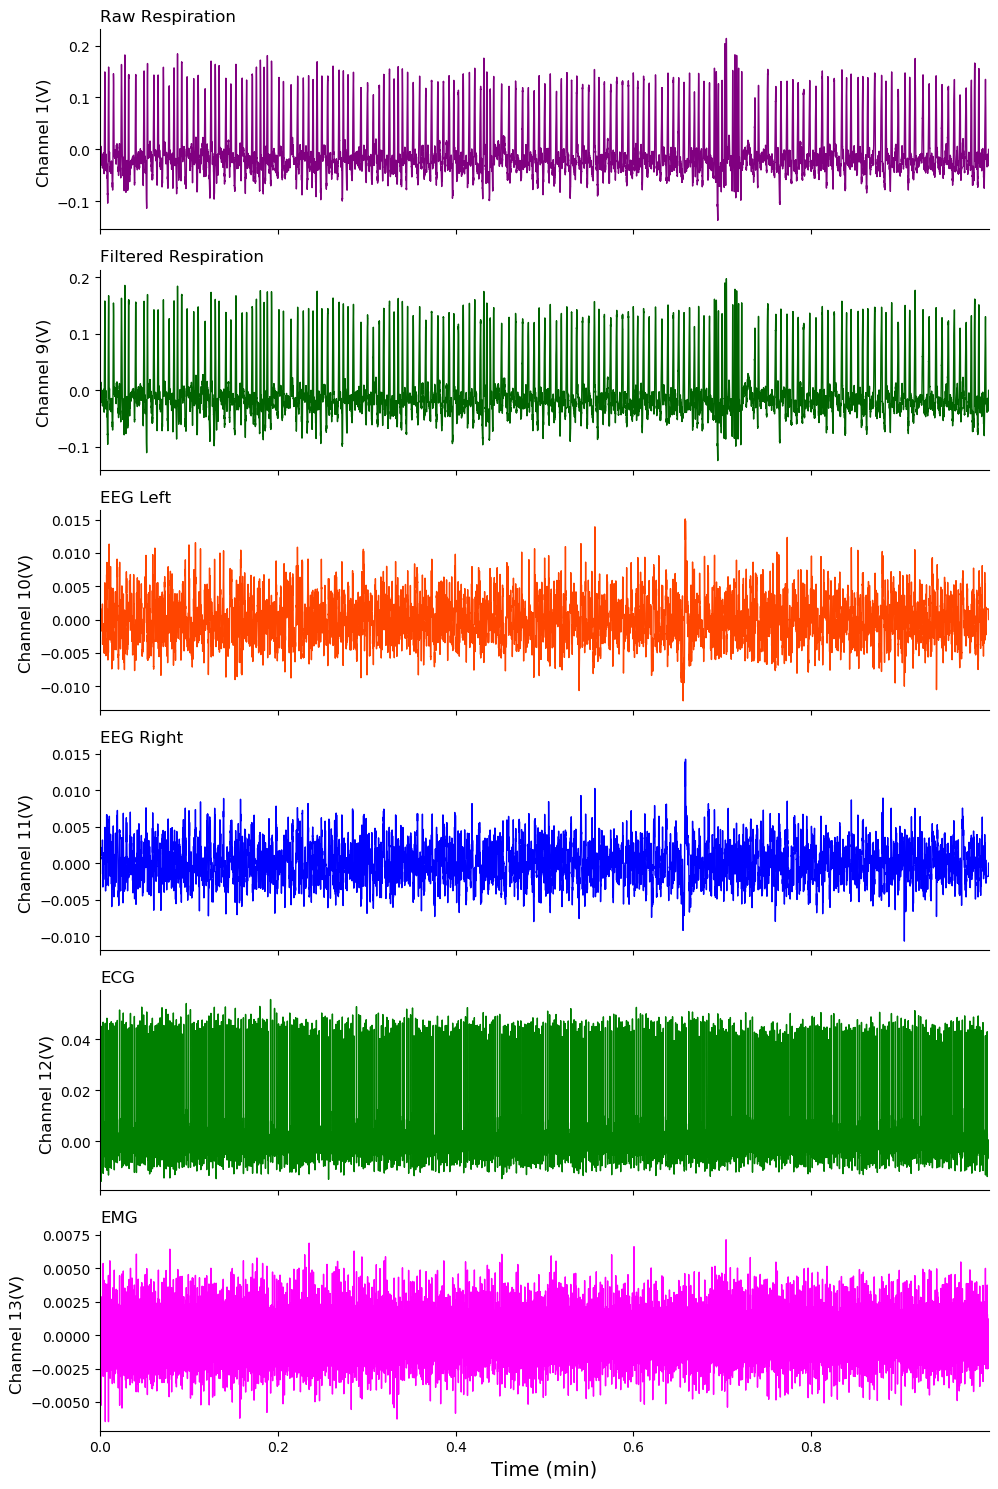

In [7]:
def plot_all(signals, sigbufs,signal_labels, start, end):
    """ Takes lists of signals (channel-1 since python starts at 0), signal data (sigbufs),
        and signal labels and plots the data for each channel """
    fig_rows = len(signals)
    fig_cols = 1
    i = 0

    fig, [ax1,ax2,ax3,ax4,ax5,ax6] = plt.subplots(fig_rows, fig_cols, sharex=True, figsize = (10,15), dpi = 100)
    for i in range (0,len (signals)):
        signal = signals[i]
        time = list(range(0,len(sigbufs[0,start:end])))
        x = []
        for t in time:
            tmp = t/60000
            x.append(tmp)
        
        if i == 0: # Ch8
            y = sigbufs[signal,start:end]
            ax1.plot(x,y, lw = 1, color = "purple")
            ax1.spines['top'].set_visible(False)
            ax1.spines['right'].set_visible(False)
            ax1.set_xlim (0, max(x))
            ax1.set_title ('Raw Respiration', loc = 'left')
            ax1.set_ylabel(signal_labels[i] + "(V) ", fontsize = 12)
            
        elif i == 1: # Ch9
            y = sigbufs[signal,start:end]
            ax2.plot(x,y, lw = 1, color = "darkgreen")
            ax2.spines['top'].set_visible(False)
            ax2.spines['right'].set_visible(False)
            ax2.set_ylabel(signal_labels[signals[i]] + "(V) ", fontsize = 12)
            ax2.set_title ('Filtered Respiration', loc = 'left')
        elif i == 2: # Ch10
            y = sigbufs[signal,start:end]
            ax3.plot(x,y, lw = 1, color = "orangered")
            ax3.spines['top'].set_visible(False)
            ax3.spines['right'].set_visible(False)
            ax3.set_ylabel(signal_labels[signals[i]] + "(V) ", fontsize = 12)
            ax3.set_title ('EEG Left', loc = 'left')
        elif i == 3: # Ch11
            y = sigbufs[signal,start:end]
            ax4.plot(x,y, lw = 1, color = "blue")
            ax4.spines['top'].set_visible(False)
            ax4.spines['right'].set_visible(False)
            ax4.set_ylabel(signal_labels[signals[i]] + "(V) ", fontsize = 12)
            ax4.set_title ('EEG Right', loc = 'left')
        elif i == 4: # Ch12
            y = sigbufs[signal,start:end]
            ax5.plot(x,y, lw = 1, color = "green")
            ax5.spines['top'].set_visible(False)
            ax5.spines['right'].set_visible(False)
            ax5.set_ylabel(signal_labels[signals[i]] + "(V) ", fontsize = 12)
            ax5.set_title ('ECG', loc = 'left')
        elif i == 5: # Ch13
            y = sigbufs[signal,start:end]
            ax6.plot(x,y, lw = 1, color = "magenta")
            ax6.set_xlabel ("Time (min)", fontsize = 14)
            ax6.spines['top'].set_visible(False)
            ax6.spines['right'].set_visible(False)
            ax6.set_ylabel(signal_labels[signals[i]] + "(V) ", fontsize = 12)
            ax6.set_title ('EMG', loc = 'left')
        elif i == 6: # Ch14
            y = sigbufs[signal,start:end]
            ax7.plot(x,y, lw = 1, color = "magenta")
            ax7.set_xlabel ("Time (min)", fontsize = 14)
            ax7.spines['top'].set_visible(False)
            ax7.spines['right'].set_visible(False)
            ax7.set_ylabel(signal_labels[signals[i]] + "(BPM) ", fontsize = 12)
            ax7.set_title ('Respiration Rate', loc = 'left')
        elif i == 7: # Ch14
            y = sigbufs[signal,start:end] 
            ax8.plot(x,y, lw = 1, color = "blue")
            ax8.set_xlabel ("Time (min)", fontsize = 14)
            ax8.spines['top'].set_visible(False)
            ax8.spines['right'].set_visible(False)
            ax8.set_ylabel(signal_labels[signals[i]] + "(BPM) ", fontsize = 12)
            ax8.set_title ('Instantaneous Heart Rate', loc = 'left')
        elif i == 8: # Ch14
            y = sigbufs[signal,start:end]
            ax9.scatter(x,y, s = 1, marker = ".", color = "black")
            ax9.set_xlabel ("Time (min)", fontsize = 14)
            ax9.spines['top'].set_visible(False)
            ax9.spines['right'].set_visible(False)     
            ax9.set_ylabel(signal_labels[signals[i]] + "(V) ", fontsize = 12)
            ax9.set_title ('Synchrony', loc = 'left')
        i = i + 1
    fig.tight_layout()

plot_all(all_signals, sigbufs,signal_labels,plot_start_time_dp, plot_end_time_dp)

### Define Templates

* Uses default threshold of 0 from baseline (also default 0) for the first pass
* Adjusts baseline by finding the moving average and standard deviation while excluding any outliers (> 2* the  std dev)
* Saves excluded data as templates for events
* (Optional) Plot the data with putative events marked

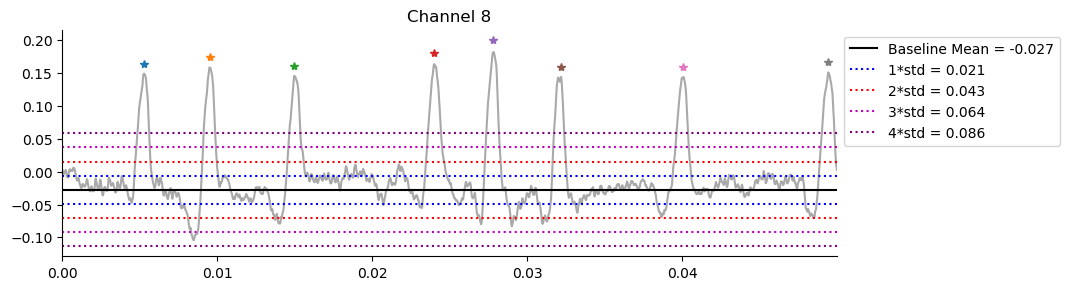

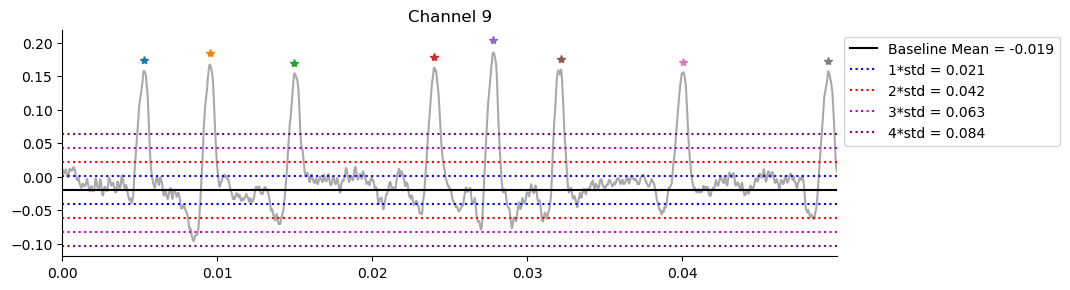

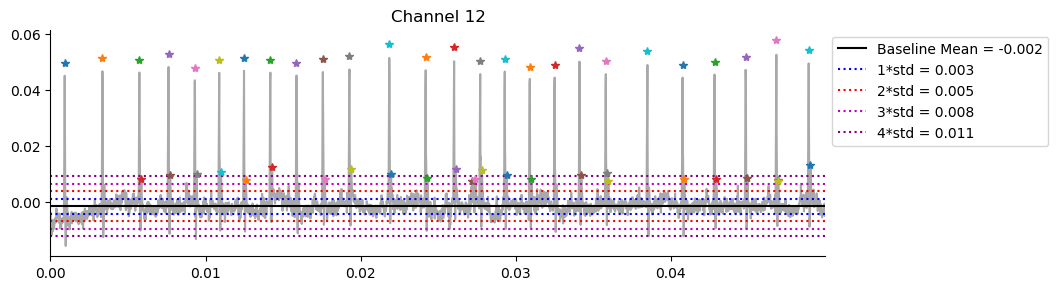

In [8]:
def get_event(start, length, signal, sigbufs, threshold, baseline, plot_results):
    """ Searches the trace for the specified length (in datapoints) based on the user-specified
        threshold and baseline, with option to plot the results (True/False)"""
    events = []
    x = list(range(0,len(sigbufs[signal,start:length])))
    y = sigbufs[signal,start:length]
    if threshold == 0: # first pass will always assume 0 (ground) in template search
        threshold = ((max(y) - min(y))*.1) 
    
    event_peaks_x = []
    event_peaks_y = []
    event_widths = []
    event_half_widths = []
    baseline_x = []
    baseline_y = []
    peak_y = 0
    i = 0
    while i < len(x)-1:
        if y[i] < threshold and y[i] > -1*threshold:     
            while y[i] < threshold and i < len(x)-1:
                baseline_x.append (x[i])
                baseline_y.append (y[i])
                i = i + 1
        elif y[i] >= threshold:
            event_x = []
            event_y = []
            peak_x = 0
            peak_y = 0
            while y[i] > threshold and i < len(x)-1:
                event_x.append (x[i])
                event_y.append (y[i])
                if y[i] > peak_y:
                    peak_y = y[i]
                    peak_x = x[i]
                i = i + 1
            event_peaks_x.append(peak_x)
            event_peaks_y.append(peak_y-baseline)
            width = max(event_x)-min(event_x)
            event_widths.append(width)
            event = {'signal': signal, 'x': event_x, 'y': event_y, 'peak_y': peak_y, 'peak_x': peak_x, 'width': width}
            events.append (event)
        else: 
            i = i + 1
    baseline_mean = np.mean(baseline_y)
    baseline_std = np.std(baseline_y)
    
    
    if plot_results == True:
        fig, ax = plt.subplots(figsize = (10,3), dpi = 100)
        
        ax.plot(datapoints_to_minutes(x), sigbufs[signal,start:length], color = 'darkgray')
        ax.axhline(baseline_mean, color = "k", ls = "solid", label = "Baseline Mean = " + str(round(baseline_mean,3)))
        ax.axhline(baseline_mean + baseline_std, color='b', linestyle=':', label = "1*std = " + str(round(baseline_std,3)))
        ax.axhline(baseline_mean + 2*baseline_std, color='r', linestyle=':', label = "2*std = " + str(round(baseline_std*2,3)))
        ax.axhline(baseline_mean + 3*baseline_std, color='m', linestyle=':', label = "3*std = " + str(round(baseline_std*3,3)))
        ax.axhline(baseline_mean + 4*baseline_std, color='purple', linestyle=':', label = "4*std = " + str(round(baseline_std*4,3)))
        ax.axhline(baseline_mean - baseline_std , color='b', linestyle=':')
        ax.axhline(baseline_mean - 2*baseline_std, color='r', linestyle=':')
        ax.axhline(baseline_mean - 3*baseline_std, color='m', linestyle=':')
        ax.axhline(baseline_mean - 4*baseline_std, color='purple', linestyle=':')
        
        ax.set_xlim(datapoints_to_minutes(min(x)),datapoints_to_minutes(max(x)))    
        ax.spines['top'].set_visible (False)
        ax.spines['right'].set_visible (False)
        ax.set_title ('Channel ' + str(signal+1))
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, bbox_to_anchor=(1, 1))
        
        for event in events:
            x = event['peak_x']
            ax.plot(datapoints_to_minutes(x), event['peak_y']*.1 + event['peak_y'], ls=None, marker='*')
            
    return [event_peaks_x, event_peaks_y, event_widths, event_half_widths, 
            np.mean(baseline_y), np.std(baseline_y),events] 


baseline = []
std = []
for signal in amp_signals:
    threshold = 0
    if signal < 13:
        search_result = get_event(template_start_time_dp, template_search_length_dp, 
                                  signal, sigbufs, threshold, ground, True)
        """ search_result = event_peaks_x, event_peaks_y, event_widths, event_half_widths, 
            np.mean(baseline_y), np.std(baseline_y),events
           """
        baseline.append(search_result[4])
        std.append(search_result[5])



### Refine Event Search

* Use the plots above to determine which standard deviation you want to use as your threshold. 
* The higher the standard deviation, the more stringent the event detection rules.
* Potential upgrade: Use event width or half-width to refine templates

In [9]:
thresh_ch8 = 4    # Default = 4
thresh_ch9 = 4    # Default = 4
thresh_ch12 = 8   # Default = 6 Avoids contamination of Q-R peak by P or T

### Tag and measure events

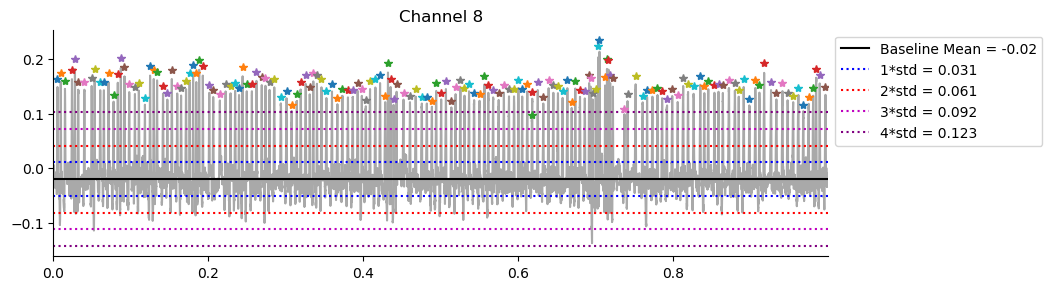

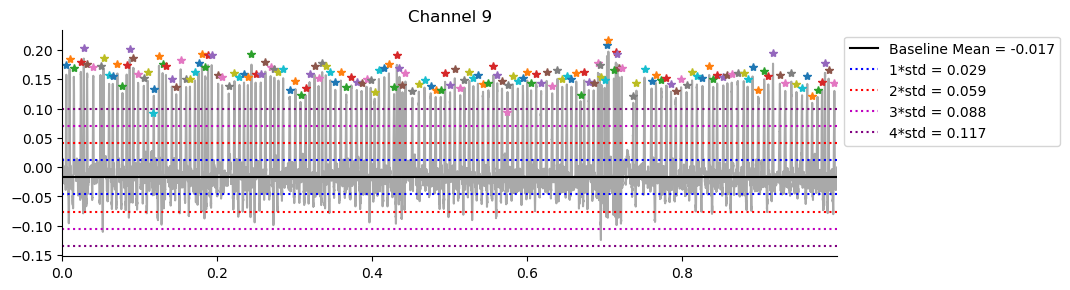

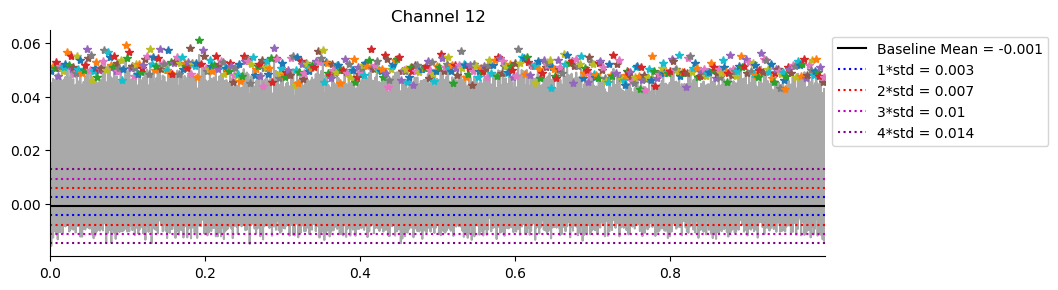

In [10]:
thresholds = [thresh_ch8, thresh_ch9, thresh_ch12]
i = 0
events_list = []
events_xmax = []
events_ymax = []
for threshold in thresholds:
    threshold = std[i] * threshold
    # Default is to search and plot the entire trace
    search_result = get_event (plot_start_time_dp, plot_end_time_dp, amp_signals[i], sigbufs, threshold, baseline[i], True)
    """search_result = event_peaks_x, event_peaks_y, event_widths, event_half_widths, np.mean(baseline_y), 
        np.std(baseline_y),events, x (in datapoints)
           """
    events_list.append(search_result[6])
    events_xmax.append (int(max(search_result[2]))+1)
    events_ymax.append (np.mean(search_result[1]))
    i = i + 1


### Plot events with mean overlayed

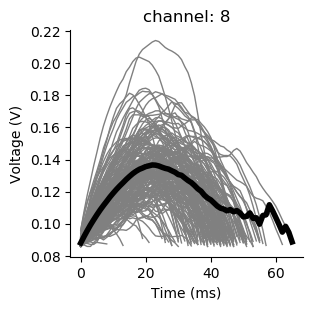

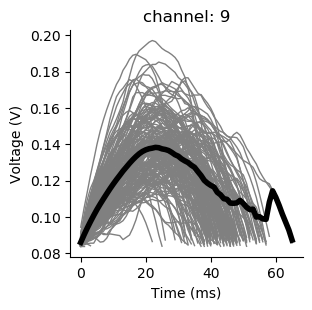

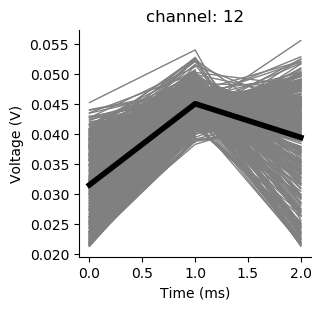

In [11]:
def plot_events (events, event_xmax, event_ymax): # For each sognal, for each event, plot the event
    fig, ax = plt.subplots (figsize = (3,3), dpi = 100)
    ax.spines ['top'].set_visible (False)
    ax.spines ['right'].set_visible (False)
    x = list(range(event_xmax))
    y = [0] * event_xmax
    n = [0] * event_xmax
    y_mean = [np.nan] * event_xmax
    for event in events:
        i = 0
        for event_y in event['y']:
            if i < len(x):
                y[i] = y[i] + event_y
                n[i] = n[i] + 1
                i = i + 1
            else:
                i = 0
                y[i] = y[i] + event_y
                n[i] = n[i] + 1
                i = i + 1
        event_x = list(range(len(event['y'])))
        ax.plot (datapoints_to_ms(event_x), event['y'], color = 'gray', lw = 1)
    i = 0
    while i < len(x): 
        if np.isnan(y[i]) == False:
            y_mean[i] = y[i]/n[i]
        i = i + 1
         
    ax.plot (datapoints_to_ms(x), y_mean, color = 'black', lw = 4)
    ax.set_title('channel: ' + str(event['signal'] +1))
    ax.set_xlabel ("Time (ms)")
    ax.set_ylabel ("Voltage (V)")


for i in range(len(events_list)):
    plot_events(events_list[i], events_xmax[i], events_ymax[i])

### Calculate latencies of cardiac events relative too respiratory events

* Takes the event list and parses it for heartbeats (ECG signal 11/channel 12) relative to breath peaks
* In the background, calculates latency of each heartbeat relative to the most recent breath peak
* Calculates the the width of events relative to the most recent breath peak
* Plots the number of cardiac events (y) relative to the most recent breath peak (0)

In [12]:
def get_hrv (events_list):
    """The way Lab Chart is set up: 
        Channel 8 (event_list[0]) is unfiltered respiratory data)
        Channel 9 (event_list[1]) is 100Hz filtered respiratory data)
        Channel 12 (event_list[2] is cardiac data/EMG)
    """
    breath_events = events_list[1]
    heart_events = events_list[2]
    epochs = []
    i = 0 # Breath counter
    j = 0 # Heartbeat counter
    while i < len(breath_events)-1:
        heartbeats_x = []
        heartbeats_y = []
        heartbeats_width = []
        latencies = []
    
        if heart_events[j]['peak_x'] < breath_events[0]['peak_x']:
            j = j + 1
        else:
            while heart_events[j]['peak_x'] >= breath_events[i]['peak_x'] and heart_events[j]['peak_x'] < breath_events[i+1]['peak_x']:
                #print(heart_events[j]['peak_x'], breath_events[i]['peak_x'], breath_events[i+1]['peak_x'])
                heartbeats_x.append(heart_events[j]['peak_x'])
                heartbeats_y.append(heart_events[j]['peak_y'])                
                heartbeats_width.append(heart_events[j]['width'])
                latencies.append(heart_events[j]['peak_x']-breath_events[i]['peak_x'])
                j = j + 1
            epoch_length = breath_events[i+1]['peak_x'] - breath_events[i]['peak_x']
            epoch = {'breath_x': breath_events[i]['peak_x'], 'heartbeats_x': heartbeats_x, 'heartbeats_y': heartbeats_y, 
                     'breaths_width': breath_events[i]['width'], 'heartbeats_width': heartbeats_width, 
                     'epoch_length':epoch_length, 'latencies':latencies}
            epochs.append(epoch)
            i = i + 1
    return epochs


"""'Each epoch contains: breath_x, heartbeats_x, heartbeats_y, breaths_width, heartbeats_width, epoch_length, latencies""" 
epochs = get_hrv (events_list)


### Get the duration of breath peaks (Subset)

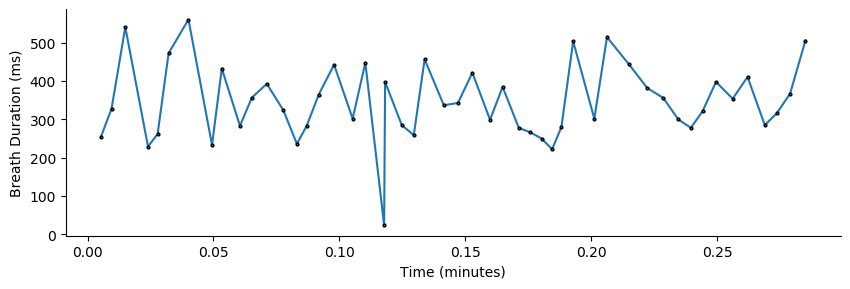

In [13]:
def get_breath_durations (epochs):
    breath_peak_times = []
    breath_durations = []
    i = 0 
    while i < len(epochs)-1:
        breath_peak_times.append (epochs[i]['breath_x'])
        breath_durations.append (epochs[i+1]['breath_x'] - epochs[i]['breath_x'])
        i = i + 1
    return breath_peak_times, breath_durations

breath_peak_times, breath_durations = get_breath_durations (epochs)   

"""Plot the whole trace with breath_times[:], heart_latencies[:] or a 
    subset by passing the first event and last event you're interested in. 
    For example, to visualize events 0-50, pass breath_times[0:50], heart_latencies[0:50] """
fig, ax = plot_anything (breath_peak_times[0:50], breath_durations[0:50], 'ms', 'Time (minutes)', 'Breath Duration (ms)', True) 


### Get the duration of breath peaks (Full)

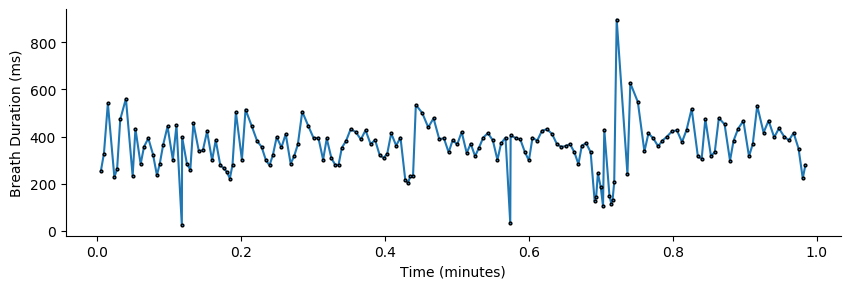

In [14]:
fig, ax = plot_anything (breath_peak_times[:], breath_durations[:], 'ms', 'Time (minutes)', 'Breath Duration (ms)', True) 

### Plot the relationship of cardiac events to each respiratory event (Subset)

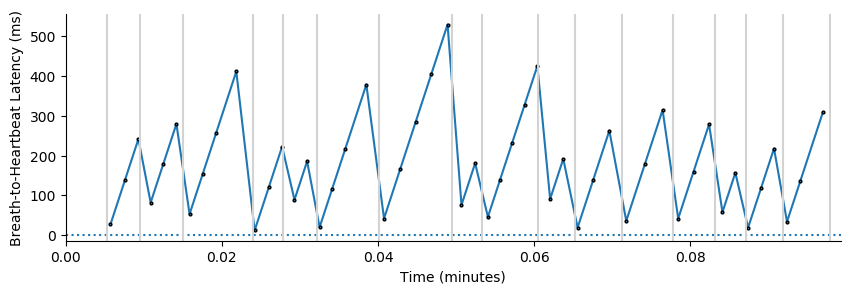

In [82]:
def get_latencies (epochs):
    breath_times = []
    heart_times = []
    heart_latencies = []
    for epoch in epochs:
        breath_times.append (epoch['breath_x'])
        for beat_y in epoch['latencies']:
            heart_latencies.append(beat_y)
        for beat_x in epoch['heartbeats_x']:
            heart_times.append(beat_x)
    return breath_times, heart_times, heart_latencies

breath_times, heart_times, heart_latencies = get_latencies (epochs)
"""Plot the whole trace with breath_times[:], heart_latencies[:] or a 
    subset by passing the first event and last event you're interested in. 
    For example, to visualize events 0-50, pass breath_times[0:50], heart_latencies[0:50] """
fig, ax = plot_anything (heart_times[0:50], heart_latencies[0:50], 'ms', 'Time (minutes)', 'Breath-to-Heartbeat Latency (ms)', True) 
ax.axhline (0, ls= ':')
for breath in breath_times[0:50]:
    ax.axvline(datapoints_to_minutes(breath), color = 'lightgray')
lims = ax.set_xlim(0,datapoints_to_minutes(heart_times[50]))


### Plot the relationship of cardiac events to eac respiratory event (Full)

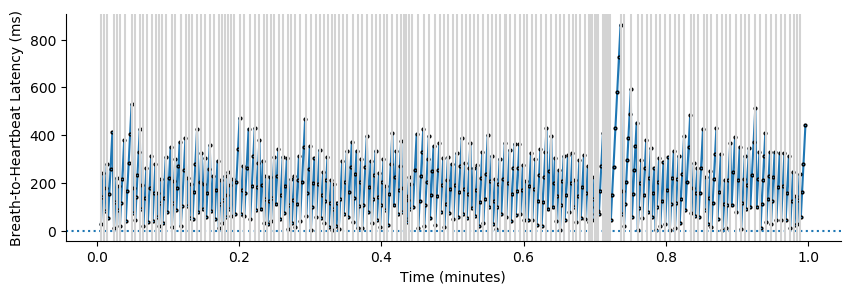

In [83]:
fig, ax = plot_anything (heart_times[:], heart_latencies[:], 'ms', 'Time (minutes)', 'Breath-to-Heartbeat Latency (ms)', True) 
ax.axhline (0, ls= ':')
for breath in breath_times:
    ax.axvline(datapoints_to_minutes(breath), color = 'lightgray')

### Get Time Delay Value as Percent of Full Breath Duration (Subset)

(0, 0.09923333333333334)

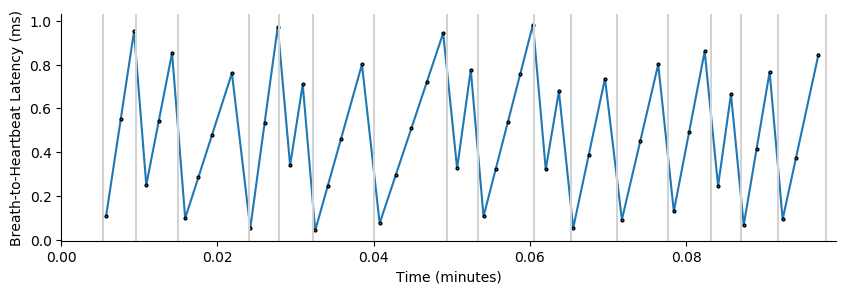

In [86]:
def get_latencies_as_fraction (epochs, breath_durations):
    breath_times = []
    heart_times = []
    heart_latencies_fraction = []
    i = 0
    for epoch in epochs:
        breath_times.append (epoch['breath_x'])
        for beat_y in epoch['latencies']:
            if i < len(breath_durations)-1:
                heart_latencies_fraction.append(beat_y/breath_durations[i])
        for beat_x in epoch['heartbeats_x']:
            if i < len(breath_durations)-1:
                heart_times.append(beat_x)
        i = i + 1
    return breath_times, heart_times, heart_latencies_fraction, breath_durations


breath_times, heart_times, heart_latencies_fraction, breath_durations = get_latencies_as_fraction(epochs, breath_durations)
fig, ax = plot_anything (heart_times[0:50], heart_latencies_fraction[0:50], 'none', 'Time (minutes)', 'Breath-to-Heartbeat Latency (ms)', True) 
for breath in breath_times:
    ax.axvline(datapoints_to_minutes(breath), color = "lightgray")
ax.set_xlim(0, datapoints_to_minutes(heart_times[50]))


### Get Time Delay Value as Percent of Full Breath Duration (Full)

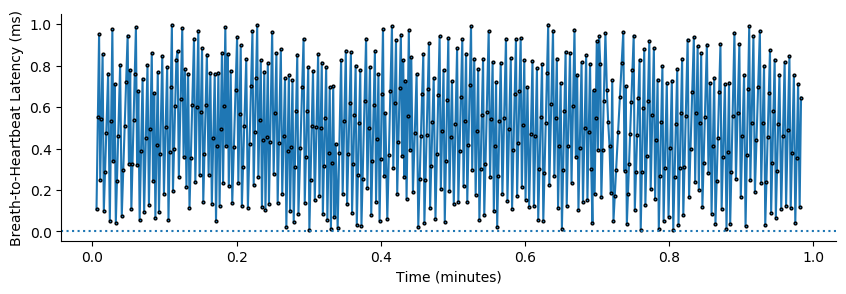

In [88]:
breath_times, heart_times, heart_latencies_fraction, breath_durations = get_latencies_as_fraction(epochs, breath_durations)
fig, ax = plot_anything (heart_times[:], heart_latencies_fraction[:], 'none', 'Time (minutes)', 'Breath-to-Heartbeat Latency (ms)', True) 
ax.axhline (0, ls= ':')
#for breath in breath_times:
#    ax.axvline(datapoints_to_minutes(breath), color = "lightgray")

In [113]:
def save_csv (df_out, file_out, dir_out):
    """Saves the dataframe to a csv spreadsheet in the specified directory. """
    try:
        os.stat(dir_out)
    except:
        os.makedirs(dir_out)

    # Write data to file
    os.chdir(dir_out)
    df_out.to_csv(file_out, index = True)
  

row = {}
df = pd.DataFrame(row)
i = 0
for epoch in epochs:
    j = 0
    if i < len(breath_durations):
        for beat in epoch['heartbeats_x']:
            row['R_time'] = epoch['breath_x']
            row['R_duration'] = breath_durations[i]
            row['C_time'] = beat
            row['C_R_latency'] = beat - epoch['breath_x']
            row['C_R_fraction'] = row['C_R_latency'] / breath_durations[i] 
            row['C_index'] = j+1
            row['C_C_latency'] = beat - epoch['heartbeats_x'][j-1]
            df = df.append(row, ignore_index = True)
            j = j + 1
        i = i + 1
df = df[['R_time', 'R_duration', 'C_time', 'C_R_latency', 'C_R_fraction', 'C_index', 'C_C_latency']]
display(HTML(df.to_html()))
save_csv(df, file_in.replace('.edf', '.csv'), dir_in)


,R_time,R_duration,C_time,C_R_latency,C_R_fraction,C_index,C_C_latency
0,317.0,254.0,344.0,27.0,0.106299,1.0,-215.0
1,317.0,254.0,457.0,140.0,0.551181,2.0,113.0
2,317.0,254.0,559.0,242.0,0.952756,3.0,102.0
3,571.0,328.0,653.0,82.0,0.250000,1.0,-198.0
4,571.0,328.0,749.0,178.0,0.542683,2.0,96.0
5,571.0,328.0,851.0,280.0,0.853659,3.0,102.0
6,899.0,541.0,952.0,53.0,0.097967,1.0,-359.0
7,899.0,541.0,1054.0,155.0,0.286506,2.0,102.0
8,899.0,541.0,1157.0,258.0,0.476895,3.0,103.0
9,899.0,541.0,1311.0,412.0,0.761553,4.0,154.0


### Poincare plot

(0, 200)

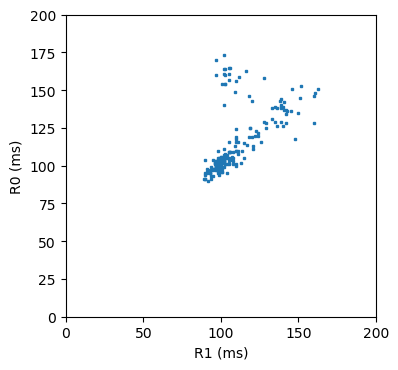

In [119]:
i = 0
x = []
y = []
while i < len(df.C_C_latency)-1:
    if df.C_C_latency[i] > 0 and df.C_C_latency[i+1] > 0:
        x.append(df.C_C_latency[i])
        y.append(df.C_C_latency[i+1])
    i = i + 1
fig, ax = plt.subplots (figsize = (4,4), dpi = 100)
ax.plot (x, y, ls = 'none', marker = 's', markersize = 2)
ax.set_xlabel ('R1 (ms)')
ax.set_ylabel ('R0 (ms)')
ax.set_xlim(0,200)
ax.set_ylim (0,200)

### Spectral Density of EMG and EEG

In [ ]:
def get_fft(signal, start, end):
    """User specifies the signal and the start and end points in minutes. Function converts minutes 
    to datapoints then calculates the spectral density of the given signal for that time frame"""
    start = minutes_to_datapoints(start)
    end = minutes_to_datapoints(end)
    fft_result = np.fft.rfft((sigbufs[signal,start:end]))
    return fft_result

fft_10 = get_fft(9, 0, 0.5)  # Left Hemisphere EEG, channel 10, signal 9
fft_11 = get_fft (10, 0, 0.5) # Right Hemisphere EEG, channel 11, signal 10
fft_13 = get_fft (12,0, 0.5)  # EMG, channel 13, signal 12

fft_list = [fft_10, fft_11, fft_13]
freq_labels = ['Left Hemisphere EEG', 'Right Hemisphere EEG', 'EMG']

In [ ]:
def plot_fft (channel, label, fft):
    fig, ax = plt.subplots(4,1, figsize=(10,10), dpi = 100)
    ax[0].set_title ("Channel " + str(channel) + ': ' + label)
    ax[0].plot(fft[0:2000])
    ax[0].set_xlim (0,2000)
    ax[1].plot(fft[0:1000])
    ax[1].set_xlim (0,1000)
    ax[1].set_ylabel ('Spectral Density (V' + r'$^2$' + '/Hz)')
    ax[2].plot(fft[0:500])
    ax[2].set_xlim (0,500)
    ax[3].plot(fft[0:250])
    ax[3].set_xlim (0,250)


i = 0
for fft in fft_list:
    plot_fft(freq_signals[i], freq_labels[i], fft_list[i])
    i = i + 1

In [ ]:
### Scan entire trace for regions of increased activity in particular frequency bands
### Meet with Franck to determine threshold for detection